In [13]:
# Import packages
import os

import earthpy as et
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# Download data
et.data.get_data('spatial-vector-lidar')

# Set working directory
working_dir = os.path.join(et.io.HOME, 'earth-analytics', 'data')
if not os.path.exists(working_dir):
    print('Working directory {} does not exist. Creating...'
          .format(working_dir))
    os.makedirs(working_dir)

os.chdir(working_dir)
print('Working directory changed to {}'.format(working_dir))

Working directory changed to /Users/elsa/earth-analytics/data


In [3]:
%%bash
find spatial-vector-lidar/california | grep crop

spatial-vector-lidar/california/neon-sjer-site/vector_data/SJER_crop.prj
spatial-vector-lidar/california/neon-sjer-site/vector_data/SJER_crop.qpj
spatial-vector-lidar/california/neon-sjer-site/vector_data/SJER_crop2.prj
spatial-vector-lidar/california/neon-sjer-site/vector_data/SJER_crop2.qpj
spatial-vector-lidar/california/neon-sjer-site/vector_data/SJER_crop.shx
spatial-vector-lidar/california/neon-sjer-site/vector_data/SJER_crop.shp
spatial-vector-lidar/california/neon-sjer-site/vector_data/SJER_crop2.dbf
spatial-vector-lidar/california/neon-sjer-site/vector_data/SJER_crop2.shp
spatial-vector-lidar/california/neon-sjer-site/vector_data/SJER_crop2.shx
spatial-vector-lidar/california/neon-sjer-site/vector_data/SJER_crop.dbf
spatial-vector-lidar/california/neon-soap-site/vector_data/SOAP_crop.qpj
spatial-vector-lidar/california/neon-soap-site/vector_data/SOAP_crop.prj
spatial-vector-lidar/california/neon-soap-site/vector_data/SOAP_crop2.prj
spatial-vector-lidar/california/neon-soap-sit

In [4]:
# Set California data path
ca_path = os.path.join(
    'spatial-vector-lidar', 'california')
sjer_vector_path = os.path.join(
    ca_path, 'neon-sjer-site', 'vector_data')

# Set Madera County Roads path
madera_roads_path = os.path.join(
    ca_path, 'madera-county-roads', 'tl_2013_06039_roads.shp')

# Set SJER site centroids path
sjer_sites_path = os.path.join(
    sjer_vector_path, 'SJER_plot_centroids.shp')

# Set SJER area of interest path
sjer_aoi_path = os.path.join(
    sjer_vector_path, 'SJER_crop.shp')

for pth in [madera_roads_path, sjer_sites_path, sjer_aoi_path]:
    if os.path.exists(pth):
        print('{} exists'.format(pth))
    else:
        print('{} does not exist.'.format(pth))

spatial-vector-lidar/california/madera-county-roads/tl_2013_06039_roads.shp exists
spatial-vector-lidar/california/neon-sjer-site/vector_data/SJER_plot_centroids.shp exists
spatial-vector-lidar/california/neon-sjer-site/vector_data/SJER_crop.shp exists


In [5]:
# Import data to GeoDataFrames
madera_roads_full_gdf = gpd.read_file(madera_roads_path)
sjer_sites_full_gdf = gpd.read_file(sjer_sites_path)
sjer_aoi_gdf = gpd.read_file(sjer_aoi_path)

# Set CRSs to match
madera_roads_full_gdf = madera_roads_full_gdf.to_crs(sjer_aoi_gdf.crs)

if all([gdf.crs==sjer_aoi_gdf.crs 
        for gdf 
        in [madera_roads_full_gdf, sjer_sites_full_gdf]]):
    print('All CRSs match!')

All CRSs match!


<AxesSubplot:>

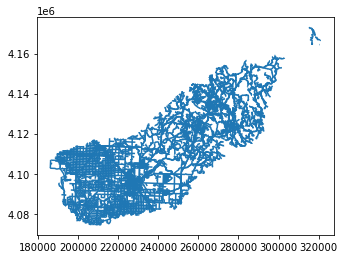

In [8]:
madera_roads_full_gdf.plot()

<AxesSubplot:>

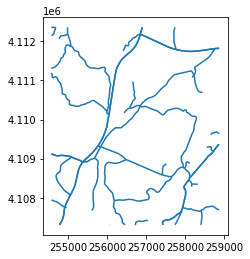

In [9]:
madera_roads_gdf = madera_roads_full_gdf.clip(sjer_aoi_gdf)
madera_roads_gdf.plot()

<AxesSubplot:>

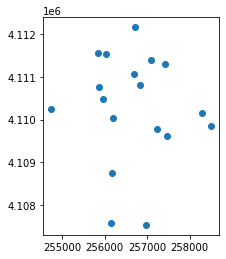

In [10]:
sjer_sites_full_gdf.plot()

<AxesSubplot:>

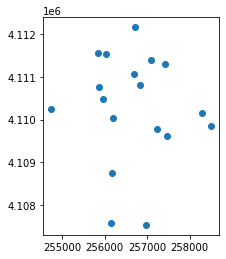

In [12]:
sjer_sites_gdf = sjer_sites_full_gdf.clip(sjer_aoi_gdf)
sjer_sites_gdf.plot()

brown
grey


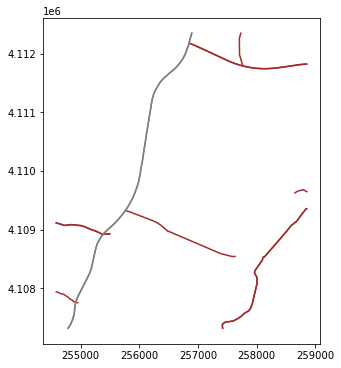

In [17]:
# Create plot
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Add road layers to plot
road_color_dict = {
    'M': 'brown',
    'S': 'grey'
}
for i, gdf in madera_roads_gdf.groupby('RTTYP'):
    gdf.plot(ax=ax, color=road_color_dict[i])